In [1]:
import os
import scipy
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

/opt/anaconda3/envs/master_project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mdata = [scipy.io.loadmat(os.path.join('data', 'mitchell', file)) for file in os.listdir('data/mitchell')]

### Filter voxel overlap

In [3]:
participants = []
for participant in mdata:
    voxel_ids = list(map(tuple, participant['meta'][0][0][7]))
    voxel_activations = participant['data']
    participants.append((voxel_ids, voxel_activations))

In [4]:
common_voxel_ids = set(participants[0][0])
for ids, _ in participants[1:]:
    common_voxel_ids.intersection_update(ids)

In [5]:
mdata_common_voxels = []
for participant in tqdm(participants):
    voxel_ids = participant[0]
    trials_activation = participant[1]
    common_activations = []
    for activations in trials_activation:
        activation_dict = {voxel_id: activation for voxel_id, activation in zip(voxel_ids, activations[0][0])}
        activations_list = []
        voxel_id_list = []
        for voxel_id in common_voxel_ids:
            activations_list.append(activation_dict[voxel_id])
            voxel_id_list.append(voxel_id)
        common_activations.append((voxel_id_list, np.array(activations_list)))
    mdata_common_voxels.append(common_activations)

100%|██████████| 9/9 [00:19<00:00,  2.11s/it]


### Voxels atlas

In [6]:
vox_atlas = scipy.io.loadmat("../mitchel_matlab/functions/ccbi_aal_atlas.mat")

### Create voxels-nouns matrix (17326 x 60)

In [7]:
arrays = {}
for i in range(len(mdata)):
    for item in mdata[i]['info'][0]:
        word = item[2][0]
        if word in arrays:
            arrays[word].append(mdata_common_voxels[i][np.where(mdata[i]['info'][0] == item)[0][0]][1])
        else:
            arrays[word] = [mdata_common_voxels[i][np.where(mdata[i]['info'][0] == item)[0][0]][1]]

In [8]:
averaged_arrays = {}
for word in arrays.keys():
    averaged_arrays[word] = np.mean(np.stack(arrays[word]), axis=0)

In [9]:
df_voxel_noun = pd.DataFrame.from_dict(averaged_arrays)

In [10]:
df_voxel_noun.head()

,refrigerator,barn,bell,key,window,screwdriver,church,desk,cow,knife,...,door,leg,carrot,watch,table,chimney,bed,fly,dog,telephone
0,-0.012514,-0.099705,0.062205,0.160798,0.089062,-0.026115,0.089495,0.117547,0.051390,0.148600,...,-0.000671,-0.034956,0.075208,-0.080399,-0.095861,-0.124346,0.152353,0.249923,0.104739,-0.082348
1,0.004073,0.150665,-0.041381,-0.032574,0.012020,-0.043047,-0.046725,0.231704,-0.043682,0.189475,...,0.007445,-0.190556,-0.038704,-0.103024,-0.143510,-0.138647,0.075204,-0.120406,0.009444,-0.063714
2,0.339468,0.165295,0.224444,0.189013,0.027443,0.224441,0.125367,0.150629,0.228366,0.397830,...,-0.008815,0.016563,0.149002,-0.066596,0.063831,0.131591,0.515392,0.223411,0.153883,-0.085430
3,-0.027404,-0.120602,0.141460,0.013487,0.087629,-0.110773,0.023360,-0.059483,0.120359,0.231212,...,-0.033112,-0.194160,-0.198997,-0.058925,-0.218875,-0.123676,0.127954,-0.156444,0.030061,-0.132323
4,0.166217,0.023788,0.200193,0.083213,0.103442,-0.200677,-0.006194,-0.090887,0.011963,0.211302,...,0.000114,0.048326,0.073113,-0.025460,-0.135332,-0.134097,0.240360,-0.004976,0.140009,-0.204470


### Glove embeddings matrix (60 x 100)

In [11]:
glove_file = os.path.join("data", "glove.6B","glove.6B.100d.txt")
with open(glove_file, 'r') as f:
    lines = f.readlines()

In [12]:
glove_embeddings = {}
for line in lines:
    word = line.split()[0]
    if word in averaged_arrays.keys():
        glove_embeddings[word] = line.split()[1:]

In [13]:
df_noun_glove = pd.DataFrame.from_dict(glove_embeddings, orient='index')

In [14]:
df_noun_glove

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
house,-0.18867,-0.040943,0.58878,0.11062,0.14236,0.4885,-0.31832,0.53819,-0.018549,0.029687,...,0.47239,-0.52798,0.65184,0.803,-0.93156,-0.055967,0.26932,0.16221,1.1238,-0.4168
cup,-0.60151,0.74661,0.65571,-0.24292,-0.43294,0.039377,0.799,0.71773,-1.1552,-0.45203,...,-0.96696,0.85978,-0.38314,0.54619,-0.10869,-0.5753,-0.13655,0.9379,0.32562,0.6938
church,0.65208,0.88673,-0.92677,0.36594,-0.27136,1.6288,-0.43925,-0.32365,0.32722,-0.094807,...,0.15486,-1.0978,-0.07903,0.86293,-0.82527,-0.87483,-0.19082,-0.41886,0.54264,0.25527
car,-0.1684,-0.53827,0.31155,-0.53218,0.26678,-0.13638,0.36621,0.68383,0.77726,0.68049,...,0.19424,0.17073,0.43663,-0.11295,-0.51156,0.34186,-0.10274,0.39684,1.734,-0.70787
key,-0.22009,0.1228,0.49666,0.014973,0.58537,-1.0869,-0.4435,-0.67389,-0.11957,-0.2751,...,-0.49754,0.5477,-0.28813,0.26786,-0.99516,0.3707,0.24787,-0.46564,0.97654,0.92977
saw,0.16038,0.030281,-0.28715,-0.18265,-0.47084,-0.06407,-0.061913,0.28301,0.15458,-0.41037,...,0.48298,-0.6071,-0.1805,0.11383,-0.79423,-0.52726,-0.13024,0.3081,0.049366,-0.15064
hand,-0.24945,0.37033,-0.058334,-0.25367,0.18709,0.8176,-0.045494,0.072066,-0.059079,-0.053018,...,-0.044007,-0.14964,0.39369,-0.014732,-0.41309,-0.061931,-0.088387,-0.23093,0.93931,0.091475
train,0.14204,0.37898,-0.041547,-0.25912,0.12683,-0.10246,-0.036349,1.1204,0.16907,0.2932,...,-0.030545,0.14088,-0.07296,0.11636,-0.49315,-0.18348,0.16653,0.24438,0.75249,-0.24142
telephone,-0.14982,-0.6223,0.14881,0.66894,0.19096,-0.028398,0.1837,0.079834,0.25051,-0.059285,...,0.78924,0.36971,0.22548,-0.23481,-0.76163,0.50806,0.16411,0.10871,0.24891,0.1303
watch,-0.38264,-0.089682,0.024723,-0.75717,-0.47556,0.61837,-0.48873,0.61044,-0.31818,-0.63448,...,0.62724,-0.29372,0.41494,-0.914,-0.3828,0.046055,0.024563,0.16366,0.43887,0.28925


### Linear regression

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
lin_reg = LinearRegression()

In [17]:
voxel_coordinates = mdata_common_voxels[0][0][0]

In [18]:
X = df_noun_glove
y = df_voxel_noun

In [19]:
df_coefficients = pd.DataFrame(index=range(y.shape[0]), columns=X.columns)
df_coefficients.index.name = 'voxel'

In [20]:
for i in tqdm(range(y.shape[0])):
    lin_reg.fit(X, y.iloc[i])
    df_coefficients.iloc[i] = lin_reg.coef_
df_coefficients['coordinates'] = voxel_coordinates

100%|██████████| 17326/17326 [00:28<00:00, 602.63it/s]


In [21]:
df_coefficients.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,coordinates
voxel,,,,,,,,,,,,,,,,,,,,,
0,-0.045861,0.009975,0.040088,0.03139,-0.030118,0.009841,0.023804,-0.041822,0.024213,0.018997,...,0.04242,0.029543,-0.025064,-0.04844,0.024435,0.02643,0.009966,0.017497,-0.055562,"(15, 32, 18)"
1,-0.100295,0.00148,0.032132,-0.018462,0.048471,0.036175,-0.024482,0.052033,0.01873,0.048699,...,0.027377,-0.012786,0.008499,-0.024556,0.003184,0.10951,0.036794,-0.0529,-0.099581,"(7, 35, 10)"
2,-0.022763,0.013733,0.033422,-0.012228,0.063099,0.01929,-0.052965,0.021552,0.009395,0.029759,...,0.085168,0.009017,0.013736,-0.038196,-0.047951,0.050595,0.022161,-0.02199,-0.090595,"(22, 11, 9)"
3,-0.159549,0.07091,0.001947,-0.057332,0.046855,0.058712,0.014557,-0.06177,0.002812,0.002595,...,0.071811,0.035363,0.042705,0.04501,-0.000949,0.027285,0.012182,0.019747,-0.004846,"(11, 18, 11)"
4,-0.058937,0.008813,-0.055833,-0.069955,0.10176,-0.057771,-0.004028,-0.078207,-0.056759,0.073035,...,0.06649,0.011537,0.032936,0.03012,-0.011792,0.03776,0.053916,-0.020091,0.034612,"(10, 40, 5)"


### Brain images

In [26]:
import nibabel as nib
from nilearn import plotting, image
from nilearn.plotting import plot_glass_brain
from scipy.ndimage import zoom

In [23]:
volume_shape = vox_atlas['Y'].shape
brain_volume = np.zeros(volume_shape)

In [31]:
for index, row in df_coefficients.iterrows():
    coordinates = row['coordinates']
    x, y, z = coordinates[0], coordinates[1], coordinates[2]
    brain_volume[x, y, z] = row[1]

In [32]:
zoom_factors = (3, 3, 6)
upsampled_brain_volume = zoom(brain_volume, zoom_factors, order=1) 

In [33]:
voxel_size = 1
affine = np.array([
    [-voxel_size, 0, 0, 78],
    [0, voxel_size, 0, -110],
    [0, 0, voxel_size, -53],
    [0, 0, 0, 1]
])

In [34]:
nii_image = nib.Nifti1Image(upsampled_brain_volume, affine=affine)

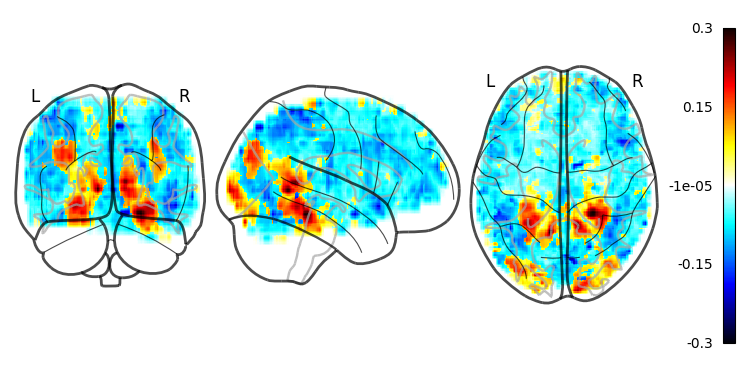

In [35]:
plot_glass_brain(nii_image, display_mode='ortho', colorbar=True, plot_abs=False)